In [1]:
import sys
!{sys.executable} -m pip install pandas_datareader
import pandas_datareader.data as pdd
import datetime as dt

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
start=dt.datetime(2009,11,1)
end=dt.datetime(2019,11,27)

lst=['AAPL','AMZN','MSFT','JPM','GOOGL','BA','LMT','WMT','C','IBM','MCO','UAL','BBY','BLK','NVDA','MCK','MRK','XOM','ORCL','NKE']
dfdc={}

for i in lst:
    df=pdd.DataReader(i, "quandl",start,end,api_key='bxpKukDn_rGbG_ygvhgV')
    df = df.reindex(index=df.index[::-1])
    df.drop(df.loc[:, 'Open':'SplitRatio'].columns, inplace=True, axis = 1)
    dfdc[i]=df

In [3]:
pip install --upgrade ta

Requirement already up-to-date: ta in c:\users\lijin\anaconda3\lib\site-packages (0.5.9)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import warnings
warnings.filterwarnings('ignore')

from ta import *

lags = 5

# Sets up the indicators

for i in dfdc:
    dfdc[i]['RSI']=momentum.rsi(dfdc[i]['AdjClose'])
    dfdc[i]['ADX']=trend.adx(dfdc[i]['AdjHigh'], dfdc[i]['AdjLow'], dfdc[i]['AdjClose'])
    dfdc[i]['PSAR_UP']=trend.psar_up(dfdc[i]['AdjHigh'], dfdc[i]['AdjLow'], dfdc[i]['AdjClose'])
    dfdc[i]['PSAR_DOWN']=trend.psar_down(dfdc[i]['AdjHigh'], dfdc[i]['AdjLow'], dfdc[i]['AdjClose'])
    dfdc[i]['EMA']=trend.ema_indicator(dfdc[i]['AdjClose'], n=5)
    dfdc[i]['EMA_diff']=dfdc[i]['EMA']-dfdc[i]['AdjClose']
    dfdc[i]['MACD']=trend.macd(dfdc[i]['AdjClose'])
    dfdc[i]['ATR']=volatility.average_true_range(dfdc[i]['AdjHigh'], dfdc[i]['AdjLow'], dfdc[i]['AdjClose'])
    dfdc[i]['SR']=momentum.stoch(dfdc[i]['AdjHigh'], dfdc[i]['AdjLow'], dfdc[i]['AdjClose'])
    for k in range(0,lags):
        dfdc[i]['RSI_' + str(k+1)] = dfdc[i]['RSI'].shift(k+1)
        dfdc[i]['ADX_' + str(k+1)] = dfdc[i]['ADX'].shift(k+1)
        dfdc[i]['PSAR_UP_' + str(k+1)] = dfdc[i]['PSAR_UP'].shift(k+1)
        dfdc[i]['PSAR_DOWN_' + str(k+1)] = dfdc[i]['PSAR_DOWN'].shift(k+1)
        dfdc[i]['EMA_diff_' + str(k+1)] = dfdc[i]['EMA_diff'].shift(k+1)
        dfdc[i]['MACD_' + str(k+1)] = dfdc[i]['MACD'].shift(k+1)
        dfdc[i]['ATR_' + str(k+1)] = dfdc[i]['ATR'].shift(k+1)
        dfdc[i]['SR_' + str(k+1)] = dfdc[i]['SR'].shift(k+1)

In [5]:
# Sets up what we are predicting and further cleans the data

for i in dfdc:
    dfdc[i]['Return'] = np.log(dfdc[i]['AdjClose'] / dfdc[i]['AdjClose'].shift(1))
    dfdc[i]['UpTick']=np.where(dfdc[i]['Return']>0, 1, 0)   # 1 if up, 0 otherwise
    dfdc[i] = dfdc[i].iloc[42:,]    # Remove all the data before Jan 1, 2010
    dfdc[i].fillna(0, inplace=True)

In [6]:
import seaborn as sns

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Splits and normalizes the data

datasize = len(dfdc[lst[0]])
trainsize = np.math.floor(0.8 * datasize)
train={}
test={}
X_train={}
X_test={}
y_train={}
y_test={}
upfreq={}
upfreq_dummy={}

for i in dfdc:
    train[i] = dfdc[i].iloc[:trainsize]
    test[i] = dfdc[i].iloc[trainsize:datasize]
    X_train[i] = train[i].filter(train[i].loc[:, 'RSI_1':'SR_5'].columns, axis = 1)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(X_train[i])
    X_train[i] = pd.DataFrame(scaler.transform(X_train[i]), index=X_train[i].index, columns=X_train[i].columns)
    X_test[i] = test[i].filter(test[i].loc[:, 'RSI_1':'SR_5'].columns, axis = 1)
    X_test[i] = pd.DataFrame(scaler.transform(X_test[i]), index=X_test[i].index, columns=X_test[i].columns)
    y_train[i] = train[i][['UpTick']]
    y_test[i] = test[i][['UpTick']]
    upfreq[i] = np.mean(train[i]['UpTick'])
    upfreq_dummy[i] = np.mean(test[i]['UpTick'])

In [8]:
from sklearn.decomposition import PCA as sklearnPCA

X_train_PCA={}
X_test_PCA={}
n=10
var_ratio=np.zeros((n, ))

sklearn_pca = sklearnPCA(n_components=n)

for i in dfdc:
    X_train_PCA[i] = sklearn_pca.fit_transform(X_train[i])
    X_test_PCA[i] = sklearn_pca.transform(X_test[i])
    var_ratio = sklearn_pca.explained_variance_ratio_ + var_ratio

var_ratio = var_ratio/len(lst)
explained_total = np.sum(var_ratio)

print(var_ratio)
print(explained_total)

[0.48642583 0.13475568 0.09845635 0.08069172 0.05892163 0.03169967
 0.02509589 0.01703703 0.01429512 0.01120463]
0.9585835408623813


In [9]:
upfreq_df = pd.DataFrame.from_dict(upfreq, orient='index')
mean_upfreq = np.mean(upfreq_df)
print('In the training data, stock goes up %.2f' %(mean_upfreq*100), '% of the time')

In the training data, stock goes up 51.49 % of the time


In [10]:
from sklearn.svm import SVC
y_pred={}
acc={}
perf={}
acc_df={}
mean_acc={}
port_performance={}
C_val = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
upfreq_test={}
mean_upfreq_test={}
cmt=np.zeros((2, 2))
cmk={}

# Grid search for optimal value of penalty parameter C

for k in C_val:
    
    for i in dfdc:
        clf = SVC(kernel='linear', C=k)
        clf.fit(X_train_PCA[i], y_train[i])
        y_pred[i] = clf.predict(X_test_PCA[i])
        acc[i] = accuracy_score(y_test[i], y_pred[i])
        test[i]['y_pred']=y_pred[i]
        test[i]['correct']=2*(test[i]['UpTick']==test[i]['y_pred'])-1        # 1 if prediction is correct, -1 otherwise
        test[i]['pct_change']=1+abs(test[i]['Return'])*test[i]['correct']    # strategy's performance each day
        perf[i]=np.prod(test[i]['pct_change'])
        upfreq_test[i] = np.mean(y_pred[i])
        cm0 = (confusion_matrix(y_test[i], y_pred[i], labels=[1, 0], sample_weight=None) / len(test[lst[0]]) )*100
        cmt = cmt + cm0
    
    print('The C value ' + str(k) + ' is checked.')   # Used to check the code is running properly
    
    # the code below is used for keeping track of the model's performance
    
    acc_df[k]=pd.DataFrame.from_dict(acc, orient='index')
    mean_acc[k]=pd.DataFrame.mean(acc_df[k])*100
    
    perf_df=pd.DataFrame.from_dict(perf, orient='index')
    port_performance[k]=(np.mean(perf_df)-1)*100
    
    upfreq_test_df = pd.DataFrame.from_dict(upfreq_test, orient='index')
    mean_upfreq_test[k] = np.mean(upfreq_test_df)*100
    
    cmk[k] = cmt
    cmt=np.zeros((2, 2))

The C value 0.0001 is checked.
The C value 0.0003 is checked.
The C value 0.001 is checked.
The C value 0.003 is checked.
The C value 0.01 is checked.
The C value 0.03 is checked.
The C value 0.1 is checked.
The C value 0.3 is checked.
The C value 1 is checked.
The C value 3 is checked.
The C value 10 is checked.
The C value 30 is checked.
The C value 100 is checked.
The C value 300 is checked.
The C value 1000 is checked.


In [11]:
upfreq_dummy_df = pd.DataFrame.from_dict(upfreq_dummy, orient='index')
mean_upfreq_dummy = np.mean(upfreq_dummy_df)
print('In the test data, stock goes up %.2f' %(mean_upfreq_dummy*100), '% of the time')

In the test data, stock goes up 53.80 % of the time


,Accuracy (%)
0.0001,53.466184
0.0003,53.466184
0.0010,53.466184
0.0030,53.586957
0.0100,53.079710
0.0300,53.031401
0.1000,52.862319
0.3000,52.789855
1.0000,52.512077
3.0000,52.475845


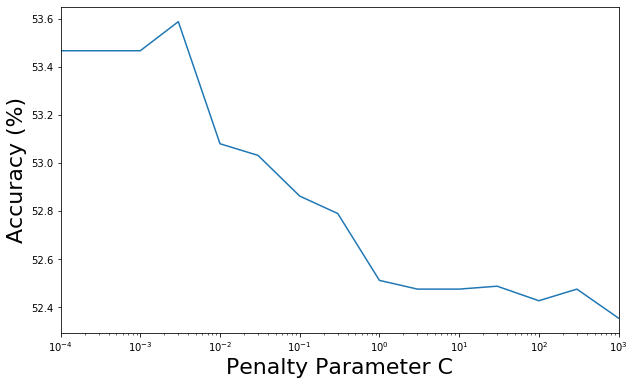

In [30]:
# This checks how accurate the model's predictions are given different values for the penalty parameter C

mean_acc_df = pd.DataFrame.from_dict(mean_acc, orient='index')
mean_acc_df.columns = ['Accuracy (%)']
mean_acc_df.plot(figsize = (10,6), legend=None)
plt.xlabel('Penalty Parameter C', fontsize=22)
plt.ylabel('Accuracy (%)', fontsize=22)
plt.xscale("log")
mean_acc_df

,Portfolio Return (%)
0.0001,49.878325
0.0003,49.878325
0.0010,49.878325
0.0030,49.566020
0.0100,43.491731
0.0300,39.490436
0.1000,36.804899
0.3000,39.329872
1.0000,34.893172
3.0000,34.874071


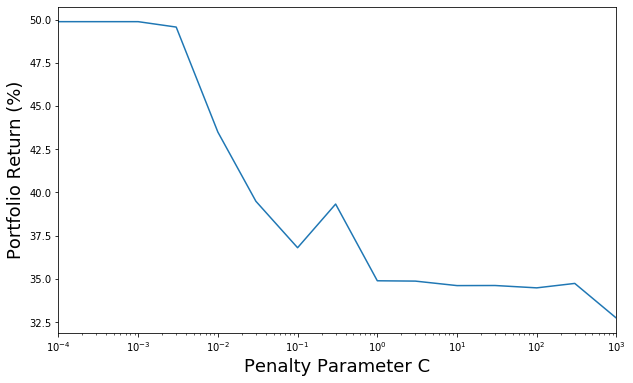

In [31]:
# This checks the strategy's total return over test period given different values for the penalty parameter C

port_performance_df = pd.DataFrame.from_dict(port_performance, orient='index')
port_performance_df.columns = ['Portfolio Return (%)']
port_performance_df.plot(figsize = (10,6), legend=None)
plt.xlabel('Penalty Parameter C', fontsize=18)
plt.ylabel('Portfolio Return (%)', fontsize=18)
plt.xscale("log")
port_performance_df

,Up Predictions (%)
0.0001,90.000000
0.0003,90.000000
0.0010,90.000000
0.0030,82.753623
0.0100,75.966184
0.0300,71.545894
0.1000,68.019324
0.3000,65.410628
1.0000,63.756039
3.0000,63.792271


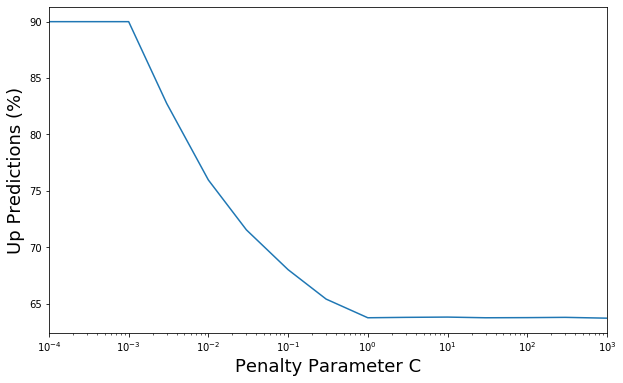

In [32]:
# This checks the frequency the model predicts the stocks to go up given different values for the penalty parameter C

mean_upfreq_test_df = pd.DataFrame.from_dict(mean_upfreq_test, orient='index')
mean_upfreq_test_df.columns = ['Up Predictions (%)']
mean_upfreq_test_df.plot(figsize = (10,6), legend=None)
plt.xlabel('Penalty Parameter C', fontsize=18)
plt.ylabel('Up Predictions (%)', fontsize=18)
plt.xscale("log")
mean_upfreq_test_df

In [33]:
C_val0 = 0.003               # Change C_val0 to any C value to report performance

print('Accuracy of SVM model = %.2f' %(mean_acc[C_val0]) + "%")
print('This strategy has a total return of %.2f' %(port_performance[C_val0]), '% of over', len(test[lst[0]]), 'trading days')
ann_performance=((port_performance[C_val0]/100+1)**(253/len(test[lst[0]]))-1)*100
print('That translates to an annualized return of %.2f' %(ann_performance), '%')

Accuracy of SVM model = 53.59%
This strategy has a total return of 49.57 % of over 414 trading days
That translates to an annualized return of 27.89 %


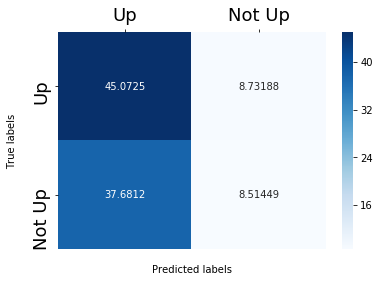

In [34]:
cm = cmk[C_val0]/len(lst)       # Change C_val0 to any C value to display confusion matrix for whole portfolio
TP = cm[0][0]                                                                                          # True Positives
FN = cm[0][1]                                                                                          # False Positives
FP = cm[1][0]                                                                                          # True Negatives
TN = cm[1][1]                                                                                          # False Negatives

plt.figure(figsize=(6, 4))      # format the plot size
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap="Blues")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['Up', 'Not Up'], fontsize=18)
ax.xaxis.set_ticklabels(['Up', 'Not Up'], fontsize=18)
plt.show()

In [35]:
acc_df[C_val0].columns = ['Accuracy (%)']
acc_df[C_val0]

,Accuracy (%)
AAPL,0.528986
AMZN,0.567633
MSFT,0.548309
JPM,0.541063
GOOGL,0.538647
BA,0.591787
LMT,0.562802
WMT,0.560386
C,0.524155
IBM,0.514493
